In [66]:
import sys
sys.path.append("..")

In [161]:
import collections

import numpy as np
import matplotlib.pyplot as plt
import pygmsh
import meshio
import pytictoc
import scipy.sparse
import scipy.interpolate

from femns2d import femns2d

In [162]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
def generate_geometry(N, r, width, p=0.05):
    with pygmsh.occ.Geometry() as geom:
        # Step 2: Add Rectangle
        geom.characteristic_length_max = p
        rectangle = geom.add_rectangle([0.0, 0.0, 0.0], width, N)

        # Step 3: Add Circles
        circles_middle = [
            geom.add_disk([0.5, float(n), 0.0], r, r) for n in range(N+1)
        ]

        circles_left = [
            geom.add_disk([0.0, n - 0.5, 0.0], r, r) for n in range(1, N+1)
        ]

        circles_right = [
            geom.add_disk([1.0, n - 0.5, 0.0], r, r) for n in range(1, N+1)
        ]
        
        # Step 4: Extrude Circles from Rectangle
        for circle in circles_middle + circles_left + circles_right:
            geom.boolean_difference([rectangle], [circle])

        # Generate mesh
        mesh = geom.generate_mesh()
    return mesh

N = 5  # Height of rectangle
r = 0.2  # Radius of circles
width = 1.0  # Width of rectangle

mesh = generate_geometry(N, r, width, p=0.1)


In [164]:
line_elements = mesh.cells_dict['line']
triangle_elements = mesh.cells_dict['triangle']
points = mesh.points

In [165]:
def extract_line_elements(triangle_elements):
    line_elements_counter = collections.defaultdict(lambda : list())
    for j, triangle in enumerate(triangle_elements):
        for i in range(3):
            # Extract the vertices of each edge and sort them to ensure uniqueness
            edge = tuple(sorted([triangle[i], triangle[(i + 1) % 3]]))
            line_elements_counter[edge].append(j)
    line_elements = np.vstack(list(line_elements_counter.keys()))
    return line_elements, line_elements_counter
line_elements, line_elements_counter = extract_line_elements(triangle_elements)
boundary_elements = new_boundary_elements = [i for i, el in enumerate(line_elements)
                                             if len(line_elements_counter[tuple(el)]) == 1]

In [166]:
boundary_maps = [(1, 0, 0.0), (2, 0, 1.0), (3, 1, 0.0), (4, 1, N)]
def get_boundary_attributes(line_elements, outer_elements, points):
    line_attributes = np.zeros(line_elements.shape[0], dtype='int')
    line_attributes[outer_elements] = 5
    for m, i, v in boundary_maps:
        inds = [j for j in range(line_elements.shape[0])
                if np.all(np.isclose(points[line_elements[j], i], v))]
        line_attributes[inds] = m
    return line_attributes

In [167]:
line_attributes = get_boundary_attributes(line_elements, boundary_elements, points)
triangle_attributes = np.zeros(triangle_elements.shape[0], dtype=int)

In [168]:
cells = [
    meshio.CellBlock("line", line_elements),
    meshio.CellBlock("triangle", triangle_elements),
]

cell_data_dict = {
    "grain": [  # Replace with the actual attribute name
        np.array(line_attributes),
        np.array(triangle_attributes),
    ]
}

mesh = meshio.Mesh(
    points=points,
    cells=cells,
    cell_data=cell_data_dict,
)
meshio.write("simple_geometry.vtk", mesh)



In [169]:
mesh = meshio.read("simple_geometry.vtk")
points = mesh.points
element_connectivity = mesh.cells_dict["triangle"]
boundary_elements = mesh.cells_dict["line"]
boundary_markers = mesh.cell_data_dict["grain"]["line"]
grain_markers = mesh.cell_data_dict['grain']['triangle']

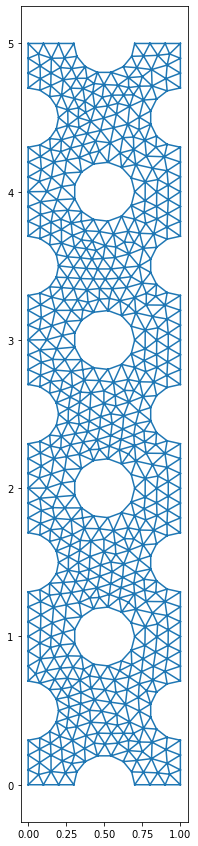

In [170]:
plt.figure(figsize=(3, 3*N))
plt.triplot(points[..., 0], points[..., 1], triangle_elements)

In [341]:
steps = 1000
dt = 1e-1
dirichlet_bcs = [[1], [3]]

nfree = 1.0
kappa = 0.1

In [342]:
assembler = femns2d.MiniAssembler(mesh)
assembler.set_main_element("linear")
assembler.set_line_elements()

In [343]:
interface_indexes = assembler.mesh.cell_data_dict['grain']['line'] == 5
base_boundary_forcing = np.zeros(line_elements.shape[0])
base_boundary_forcing[interface_indexes] = -kappa*nfree
# assembler.line_forcing_vector(lambda i : boundary_forcing[i], forcing_fn_type='element')

In [344]:
K = assembler.stiffness_matrix(stiffness_fn=1.0)
M = assembler.mass_matrix()
MKdt = M + dt*K
MKdt = assembler.apply_dirichlet_to_matrix(dirichlet_bcs[1], MKdt, where='u', data_dict_name="grain")
    
Tvalues = []
T = np.zeros(assembler.nvariables)
T = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, T, where='u', data_dict_name="grain")
Tvalues.append(T.copy())
T_lines = T[line_elements].mean(axis=-1)

MKdt = MKdt.tocsc()
LU = scipy.sparse.linalg.splu(MKdt)


for i in range(steps):
    boundary_forcing = base_boundary_forcing*T_lines
    boundary_forcing_f = assembler.line_forcing_vector(lambda i : boundary_forcing[i], forcing_fn_type='element')
    f = M@T + boundary_forcing_f
    f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, f, where='u', data_dict_name="grain")
    MKdt = MKdt.tocsc()
    T = LU.solve(f)
    T_lines = T[line_elements].mean(axis=-1)
    base_boundary_forcing *= np.exp(-T_lines*dt)
    Tvalues.append(T.copy())
t = np.arange(steps)*dt
T = np.array(Tvalues)
    

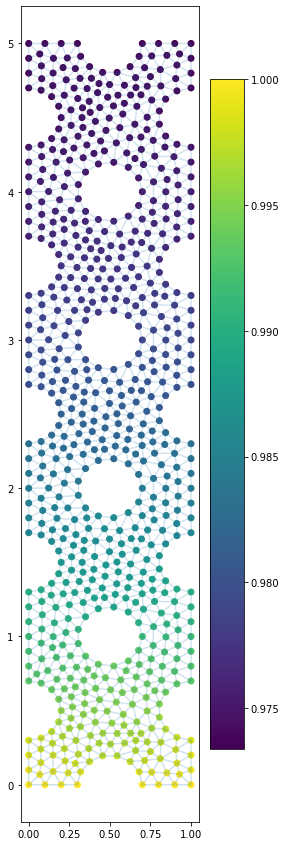

In [345]:
Ti = T[-1]
plt.figure(figsize=(4, 3*N))
plt.triplot(assembler.points[:, 0], assembler.points[:, 1], assembler.elements, alpha=0.2)
plt.scatter(assembler.points[:, 0], assembler.points[:, 1], c=Ti)
plt.colorbar()

In [346]:
np.hstack([assembler.line_elements_to_elements[tuple(l)] for l in line_elements[upper_boundary_indexes]])

array([ 76, 101, 377, 767, 768, 904])

In [347]:
upper_boundary_indexes = interface_indexes = assembler.mesh.cell_data_dict['grain']['line'] == 4
upper_boundary_elements = np.hstack([assembler.line_elements_to_elements[tuple(l)] for l in line_elements[upper_boundary_indexes]])
Tupper = [Ti[line_elements[upper_boundary_indexes]].mean() for Ti in T]

In [348]:
dTupper = [-assembler.get_linear_element_equation(Ti)[upper_boundary_elements, 1].mean() for Ti in T]

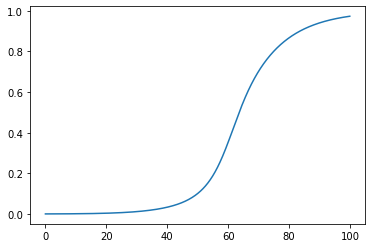

In [349]:
plt.plot(t, Tupper[:-1])